<a href="https://colab.research.google.com/github/b-irsigler/ML_MC/blob/main/causal_CNN_regressor_RayTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regressor that works on Google Colab.
Keras implementation with RayTune hyperparameter search.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/

MyDrive


In [ ]:
# workaround needed in Colab
!pip install tensorflow==2.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3 MB 13 kB/s 
     |████████████████████████████████| 449 kB 41.8 MB/s 
     |████████████████████████████████| 3.8 MB 21.9 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=40514df1b8b0b31561c863aef912045ade6ca91722b1a604e4d76befa60a1178
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [ ]:
# workaround needed in Colab
!pip install -q -U tensorflow_addons==0.6
#!pip uninstall tensorflow_addons==0.14

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 380.8 MB 41 kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import tensorflow as tf
# from tensorflow import keras
try:
    import tensorflow_addons as tfa
    print(tfa.__version__)
except ModuleNotFoundError:
    !pip install -q -U tensorflow_addons==0.6
    import tensorflow_addons as tfa
    print(tfa.__version__)

0.6.0


In [ ]:
# needed in Colab
!pip install 'ray[tune]'

     |████████████████████████████████| 54.0 MB 13 kB/s 
     |████████████████████████████████| 72 kB 518 kB/s 
     |████████████████████████████████| 124 kB 49.5 MB/s 


In [ ]:
from ray import tune
from ray.tune import JupyterNotebookReporter # CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.keras import TuneReportCallback
# https://docs.ray.io/en/latest/tune/examples/tune_mnist_keras.html

In [ ]:
# workaround needed in Colab
import os
from filelock import FileLock

In [ ]:
class CausalCNNRegressor:
    
    def load(self, num_clauses, num_mc_runs, start_temperature, number, test_size = .2):
        # workaround needed in Colab
        # https://github.com/ray-project/ray/issues/5614#issuecomment-527292289
        import tensorflow as tf
        from tensorflow import keras
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.model_selection import train_test_split
        import tensorflow_addons as tfa
        # Loads and prepares data. The path should be adjusted depending on where your 
        # data is.
        file_name = f'ec3_stim_anneal_spins{7}_clauses{num_clauses}' + \
            f'_runs{num_mc_runs}_temp{start_temperature}_{number}'
        path = f'/content/drive/MyDrive/data/raw/ec3-anneal-data_2021-10-21_1431/{file_name}.npz'
        with FileLock(os.path.expanduser("~/.data.lock")):
            data = np.load(path)
        
            ftrs = data['res_mc_timelines']
            lbls = data['res_fidelity'][:, -1]
            
            # max normalization [min,1]
            ftrs = ftrs / ftrs.max()
            # Perform min max normalization for the features [0,1]
            # ftrs = ftrs - ftrs.min()
            # ftrs /= ftrs.max() - ftrs.min()
            
            # Split train/test data for the full Hamiltonian.
            X_train, X_test, Y_train, Y_test = train_test_split(
                ftrs, lbls, test_size = test_size)
            
            self.X_train, self.X_test = X_train, X_test 
            self.Y_train, self.Y_test = Y_train, Y_test 

    def build_model(self, learn_rate, num_conv, num_dense):
        import tensorflow as tf
        from tensorflow import keras
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.model_selection import train_test_split
        import tensorflow_addons as tfa
        keras.backend.clear_session()
        model = keras.Sequential(name='Causal_CNN_regressor')
        # initial 1x1 conv to create channels (kind of regularization or data augmentation)
        model.add(keras.layers.Conv1D(2**5, (1,), activation = 'tanh', 
            padding = 'valid', strides = 1))
        # first conv with kernel_size=2 and normal stride so it covers everything with overlap
        model.add(keras.layers.Conv1D(2**2, (num_conv,), activation='tanh', 
            padding='valid', strides=1, ))#kernel_initializer='he_normal' ))#input_shape=(100,1)))
        # strided convs
        model.add(keras.layers.Conv1D(1, (2*num_conv,), activation='tanh', 
            padding='valid', strides=num_conv)) # overlap or not? yes, do it to learn pooling.
        model.add(keras.layers.Conv1D(1, (num_conv,), activation='tanh',
            padding='valid', strides=num_conv))
        model.add(keras.layers.Conv1D(1, (2*num_conv,), activation='elu', # last convolution with elu works well
            padding='valid', strides=num_conv))
        
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'sigmoid', 
        #     padding = 'valid', strides = 1))

        # 1x1 conv to reduce channels
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'elu', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.GlobalAvgPool1D(keepdims=True))

        model.add(keras.layers.Flatten()) #------------------ ----------
        
        model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        # model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        model.add(keras.layers.Dense(1, activation = 'sigmoid')) # to strict output in [0,1] range.
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'tanh', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'tanh', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Reshape((num_dense,1)))
        # model.add(keras.layers.Conv1D(1, (4,), activation = 'tanh', 
        #     padding = 'valid', strides = 2))
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'sigmoid', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Flatten())
        # model.add(keras.layers.Dense(1, activation = 'sigmoid')) # to strict output in [0,1] range.

        # Tried Cyclic learning rate scheduler, no improvement in one shot.
        # BATCH_SIZE = 128
        # INIT_LR = 1e-4
        # MAX_LR = 1e-2

        # steps_per_epoch = len(self.X_train) // BATCH_SIZE
        # clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        #     maximal_learning_rate=MAX_LR,
        #     scale_fn=lambda x: 1/(2.**(x-1)),
        #     step_size=2 * steps_per_epoch
        # )

        model.compile(loss='mae',
                      optimizer=keras.optimizers.Adam(learn_rate), # clr),
                      metrics=['mae'],
                      )

        self.model = model
        
    def training(self, epochs, batch_size=128, early=False):
        import tensorflow as tf
        from tensorflow import keras
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.model_selection import train_test_split
        import tensorflow_addons as tfa
        # Introduce early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
            patience = 100)

        callbacks =[]
        # Ray Tune needs some feedback from the training via the Callbacks
        callbacks += [TuneReportCallback({"loss": "mae", "val_loss": "val_loss",
                                        #   "iteration": "epoch"
                                          })]
        if early:
            callbacks += [stop_early]

        self.hist = self.model.fit(self.X_train, self.Y_train, epochs = epochs,
            verbose = 0,
            validation_split = .2, batch_size = batch_size,\
            callbacks = callbacks)
        

In [ ]:
# for Ray Tune to work the "Training" function argument should be a dictionary of variables,
# and, return nothing 
def regression(d):#num_clauses, num_mc_runs, start_temperature, number,
            #    lr, bsize, num_conv, num_dense,
            #    num_epochs):
    regressor = CausalCNNRegressor()
    regressor.load(d["num_clauses"], d["num_mc_runs"], d["start_temperature"], d["number"])
    regressor.build_model(d["lr"], d["num_conv"], d["num_dense"])
    regressor.training(d["num_epochs"], batch_size=d["bsize"])
    # regressor.model.summary()
    # return regressor

In [ ]:
regressor = CausalCNNRegressor()
regressor.load(5, 100, 10, 1)
regressor.build_model(1e-3, 2, 16)
regressor.training(1)
regressor.model.summary()

50/50 [==============================] - 1s 10ms/step - loss: 0.0940 - mae: 0.0940 - val_loss: 0.0907 - val_mae: 0.0907
Model: "Causal_CNN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 4)             84        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 1)             17        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 1)             3         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                400       
_________________________________________________________________
reshape (Reshape)            (None, 16, 1)             0  

In [ ]:
# regresion function changes from this
reg = regression(5, 100, 10, 1, 1e-3, 2, 16, 200)

In [ ]:
# to this function with dictionary input
regression({"num_clauses":5, "num_mc_runs":100,
          "start_temperature":10, "number":1,
          # random sampling by default
          "lr": 1e-3,
          "bsize": 512,
          "num_conv": 2,
          "num_dense":16,
          "num_epochs": 1,})

Train on 6400 samples, validate on 1600 samples
5632/6400 [=========================>....] - ETA: 0s - loss: 0.0949 - mae: 0.0949

2021-10-25 07:51:54,602	WARNING session.py:35 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2021-10-25 07:51:54,604	WARNING session.py:36 --   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib

6400/6400 [==============================] - 7s 1ms/sample - loss: 0.0946 - mae: 0.0946 - val_loss: 0.0925 - val_mae: 0.0925
Model: "Causal_CNN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  352       
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  260       
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  17        
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  3         
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  5         
_________________________________________________________________
flatten (Flatten)            multiple                

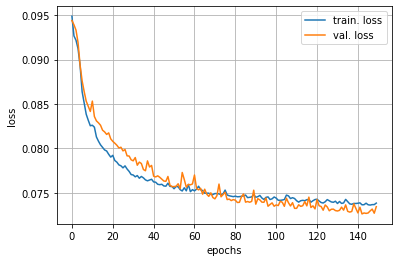

In [ ]:
plt.plot(reg.hist.history['loss'], label = 'train. loss')
plt.plot(reg.hist.history['val_loss'], label = 'val. loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend();

In [ ]:
config = {"num_clauses":5, "num_mc_runs":100,
          "start_temperature":10, "number":1,
          # random sampling by default
          "lr": tune.loguniform(5e-4, 1e-2),
          "bsize": tune.choice([2**2,2**3, 2**4,2**5,2**6,2**7,2**8]),
          "num_conv": 2,
          "num_dense":16,
          "num_epochs": 150
          # custom sampling by lambda functions
          #         "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
          #         "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
          # grid search
          # "x": tune.grid_search([1, 2, 3]),
          }
metric = "val_loss"
mode   = "min"
current_best_params = [{"lr": 1e-3,"bsize": 128,}]

In [ ]:
iter_num_epoch = 1 # how many iters per epoch
asha_scheduler = ASHAScheduler(metric=metric,mode=mode,
                            #    time_attr="iteration",
                               max_t=iter_num_epoch*300, # max time units (determined by time_attr) per trial. Can be N epochs or batches...
                               # In ASHA, you can decide how many trials are early terminated. 
                               # With grace_period=n you can force ASHA to train each trial at least for n epochs/batches/time_attr.
                               grace_period=iter_num_epoch*5,
                               # reduction_factor=20,10,4,2,1.25 means that only 5%,10%,25%,50%,80% of all trials are kept each time they are reduced.
                               reduction_factor=2)

In [ ]:
reporter_jupyter = JupyterNotebookReporter(overwrite=True, metric_columns=["loss", "val_loss", "iteration"], metric=metric,mode=mode)

In [ ]:
result = tune.run(regression, config=config,
                  #tune.with_parameters(regression, **config),
                  # name="session",
                  # partial(regression, data_dir=data_dir),
                  resources_per_trial={"cpu": 1, "gpu": 0.5},
                  num_samples=8*2, # number of random configurations (for each grid). ex.: 10*(3x3 grid)=90 configs.
            # By default, each random variable and grid search point is sampled once. 
            # However, not all of them will run at once.
            # The max training concurrency will be the number of CPU cores on the machine you're running on. For a 2-core machine, 2 models will be trained concurrently. 
                scheduler=asha_scheduler,
#                 search_alg=search_alg,
                progress_reporter=reporter_jupyter,
                verbose=1,)

Trial name,status,loc,bsize,lr,loss,val_loss
regression_4a86d_00000,TERMINATED,,64,0.000746246,0.0883415,0.0867349
regression_4a86d_00001,TERMINATED,,32,0.00704558,0.0934322,0.0928613
regression_4a86d_00002,TERMINATED,,4,0.00083152,0.0695861,0.0708601
regression_4a86d_00003,TERMINATED,,32,0.00793418,0.0940557,0.0942545
regression_4a86d_00004,TERMINATED,,8,0.000874342,0.0705609,0.0744603
regression_4a86d_00005,TERMINATED,,256,0.000781108,0.0924611,0.0950073
regression_4a86d_00006,TERMINATED,,128,0.00843193,0.0829609,0.0873416
regression_4a86d_00007,TERMINATED,,64,0.000712661,0.0926843,0.0934749
regression_4a86d_00008,TERMINATED,,8,0.00791114,0.0947285,0.093596
regression_4a86d_00009,TERMINATED,,4,0.00217659,0.0750967,0.0769778


2021-10-25 10:03:36,501	INFO tune.py:617 -- Total run time: 2374.57 seconds (2374.40 seconds for the tuning loop).


In [ ]:
# for debugging
! cat /root/ray_results/regression_2021-10-25_09-08-03/regression_0f247_00000_0_bsize=16,lr=0.0010307_2021-10-25_09-08-28/error.txt

Failure # 1 (occurred at 2021-10-25_09-08-46)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trial_runner.py", line 812, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/ray_trial_executor.py", line 767, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/dist-packages/ray/_private/client_mode_hook.py", line 89, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/ray/worker.py", line 1621, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): ray::ImplicitFunc.train_buffered() (pid=460, ip=172.28.0.2, repr=<types.ImplicitFunc object at 0x7f257ab2ca50>)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable.py", line 189, in train_buffered
    result = self.train()
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/tra

# plot hypersearch results
https://docs.ray.io/en/master/tune/api_docs/analysis.html#tune-analysis-docs

In [ ]:
from ray.tune import Analysis
# Result logdir: /root/ray_results/regression_2021-10-25_09-24-01
result = Analysis("/root/ray_results/regression_2021-10-25_09-24-01", "val_loss", "min")
best_trial_logdir = result.get_best_logdir("val_loss", "min")
print(f"Best trial config:{result.get_best_config()}")

Best trial config:{'bsize': 4, 'lr': 0.0008315204214386407, 'num_clauses': 5, 'num_conv': 2, 'num_dense': 16, 'num_epochs': 150, 'num_mc_runs': 100, 'number': 1, 'start_temperature': 10}


In [ ]:
# only for current experiment
from ray.tune import ExperimentAnalysis
# result = ExperimentAnalysis("../../ray_results/EC3_48/experiment_st
best_trial = result.get_best_trial("val_loss", "min", "all") # get_best_trial(metric, mode, scope)
# https://docs.ray.io/en/master/tune/api_docs/internals.html#trial-docstring
best_trial_logdir = best_trial.logdir
print(f"Best trial config: {best_trial.config}")

2021-10-25 10:04:09,481	WARNING experiment_analysis.py:649 -- Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: ignored

In [ ]:
if isinstance(result, ExperimentAnalysis):
    # Get a dataframe for the last reported results of all of the trials
    df_all_last = result.results_df

    # Get a list of trials
    trials = result.trials
else:
    df_all_last = result.dataframe()

In [ ]:
# works with analysis and experiment
# Get a dataframe for the min loss_test seen for each trial
df_loss_test_min = result.dataframe(metric="val_loss", mode="min")
df_loss_min = result.dataframe(metric="loss", mode="min")

# Get a dict mapping {trial logdir -> dataframes} for all trials in the experiment.
d_all = result.trial_dataframes
# In the end, it does this:
# d_all = result.fetch_trial_dataframes()

In [ ]:
df_all_last.sort_values(by=["val_loss","loss"], ascending=[1,1]).T#[25]

,13,14,11,0,1,5,4,9,12,3,8,7,6,10,2,15
loss,0.0697366,0.0701108,0.0707765,0.0747928,0.0807062,0.0826645,0.0825811,0.0883415,0.0925102,0.0934322,0.0946247,0.0926843,0.0929989,0.0941577,0.0941164,0.0924611
val_loss,0.0705841,0.072833,0.0729049,0.0742328,0.0818459,0.082108,0.0825141,0.0867349,0.0885101,0.0928613,0.0929655,0.0934749,0.0935353,0.0940735,0.0942304,0.0950073
time_this_iter_s,15.0777,1.08599,7.7055,16.223,1.1057,2.15389,0.572591,1.00183,0.595747,1.54631,7.93181,0.984774,8.21748,8.29682,1.86922,0.359983
done,False,False,False,False,True,False,False,True,True,True,False,True,True,False,False,True
timesteps_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
episodes_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
training_iteration,145,149,145,37,10,9,4,5,5,5,2,5,5,1,4,5
experiment_id,bf6f1eb66b674adbb5091d3bed28f145,203dd94ad21042feacf7d046cc2a6556,159625cda9134516ab6f06c5fd1bef3b,e99784037b114ec79f78b33334b79607,00720ce8d65a42e9bdf232c01cfa2c99,d7a333a7e3d949e5b27aa15cd6733c3e,fcf775dad998447a98d410d1c386065f,97a9d4e792e64c03ad175e8e5a832e4a,278a36807bb744daae6b5930c8bbfbae,f9dbc17e22444850bf2a950aaea0d097,ace94ce795774165a9df950fc15a940f,e6e877221c7844768b6da9ca5a7f9c98,cfa2efb45d69469fac4124ffdb424511,c8625495ee6e40c5a8af5e240731603d,7cc178ae1f9a44969c725ec8392d5230,29b1b8cf7991448a82deef1e1d32bb55
date,2021-10-25_10-01-27,2021-10-25_10-03-35,2021-10-25_09-43-28,2021-10-25_09-55-54,2021-10-25_09-57-42,2021-10-25_09-57-15,2021-10-25_09-44-37,2021-10-25_09-24-16,2021-10-25_09-57-59,2021-10-25_09-24-21,2021-10-25_09-45-25,2021-10-25_09-44-56,2021-10-25_09-58-52,2021-10-25_09-59-06,2021-10-25_09-24-40,2021-10-25_09-44-22
timestamp,1635156087,1635156215,1635155008,1635155754,1635155862,1635155835,1635155077,1635153856,1635155879,1635153861,1635155125,1635155096,1635155932,1635155946,1635153880,1635155062


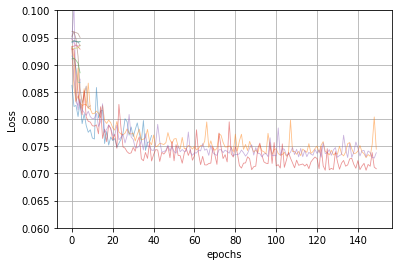

In [ ]:
ax = None
for d in d_all.values(): # plot the 3 or 4 best trials
    ax = d.val_loss.plot(ax=ax, legend=False,grid=True,
                          xlabel="epochs", ylabel="Loss",
                          alpha=0.5, #title=title,
                          style=['-'],lw=0.8,
                         );
ax.set_ylim(0.06,0.1);

In [ ]:
import matplotlib.pyplot as plt

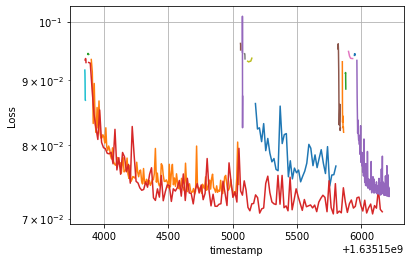

In [ ]:
# Plot by wall-clock time
ax = None
for d in d_all.values():
    ax = d.plot("timestamp", "val_loss", ax=ax, legend=False,grid=True,)
plt.yscale('log')
plt.xlabel("timestamp"); plt.ylabel("Loss");

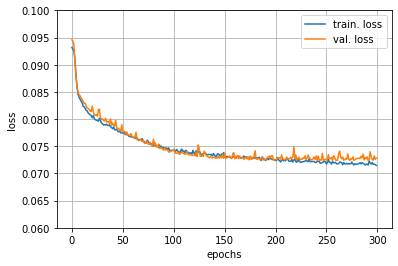

In [ ]:
plt.plot(reg.hist.history['loss'], label='train. loss')
plt.plot(reg.hist.history['val_loss'], label='val. loss')
plt.xlabel('epochs'); plt.ylabel('loss');
plt.grid(); plt.legend();
plt.ylim(0.06,0.1);

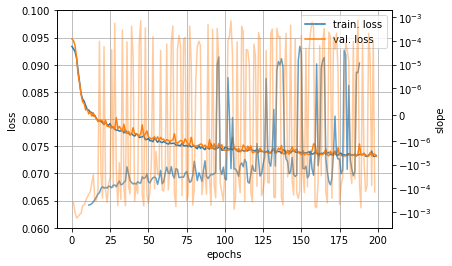

In [ ]:
plt.plot(reg.hist.history['loss'], label='train. loss')
plt.plot(reg.hist.history['val_loss'], label='val. loss')
plt.xlabel('epochs'); plt.ylabel('loss');
plt.grid(); plt.legend();
plt.ylim(0.06,0.1);

slope = (np.array(reg.hist.history['val_loss'])[2:]-np.array(reg.hist.history['val_loss'])[:-2])/3.
win = 2*10
slope_avg = np.array([slope[i:i+win].mean() for i in range(len(slope)-win)])
ax2 = plt.gca().twinx()
ax2.plot(range(1+win//2,len(reg.hist.history['val_loss'])-1-win//2),slope_avg, alpha=0.7);
ax2.plot(range(1,len(reg.hist.history['val_loss'])-1),slope, alpha=0.4);
ax2.set_ylabel('slope')
ax2.set_yscale("symlog", linthreshy=1e-6)

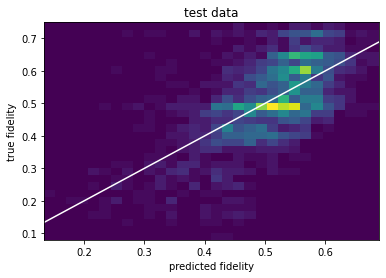

In [ ]:
plt.hist2d(reg.model.predict(reg.X_test).flatten(), reg.Y_test, bins = 30);
plt.plot([reg.Y_test.min(), reg.Y_test.max()], [reg.Y_test.min(), reg.Y_test.max()], 'w')
plt.xlabel('predicted fidelity')
plt.ylabel('true fidelity')
plt.title('test data');

In [ ]:
reg.model.summary()

Model: "Causal_CNN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 4)             84        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 2)             18        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 1)             5         
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 332
Trainable params: 332
Non-trainable params: 0
________________________________________________

In [ ]:
reg.model.summary()

Model: "Causal_CNN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 1)            11        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 4)             12        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 2)             18        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 1)             5         
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)        